In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

## Weight Initialization
In a neural network, if all weights are initialized with the same constant value, then during the backpropagation process, all the weights would be updated with the same gradient. This means that all the neurons in the hidden layer would learn the same features during training. 

This is why it’s common to initialize the weights randomly. 
Random initialization breaks the symmetry and allows the neurons to learn different features from the data
The weights should not be too small or too big otherwise it can lead to vanishing gradient or exploding gradients
. 

There are several strategies for weight initialization, such as Xavier/Glorot initialization and He initialization, which take into account the size of the previous layer in the network to scale the random weights. These methods can help speed up the convergence of the training prand prevent vanishing gradient or exploding gradientstwata.



In [2]:
torch.manual_seed(0)
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(
                                           mean=(0.5,0.5,0.5), 
                                           std=(0.5,0.5,0.5))])
trainset = datasets.CIFAR10(
    root='~/Downloads/',
    train=True,
    download=True,
    transform=transform
)

testset = datasets.CIFAR10(
    root='~/Downloads/',
    train=False,
    download=True,
    transform=transform
)

batchsize = 64
trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testloader = DataLoader(testset, batch_size=batchsize, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [58]:
device = torch.device('mps')

def weights_init_zero(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.zeros_(m.weight)
        torch.nn.init.zeros_(m.bias)
        #m.weight.data.fill_(0)
        #m.bias.data.fill_(0)

def weights_init_random(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0, std=0.01)
        torch.nn.init.normal_(m.bias, mean=0, std=0.01)
        #m.weight.data.fill_(0)
        #m.bias.data.fill_(0)

def weights_init_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight.data)
        m.bias.data.fill_(0.01)

def weights_init_kaiming(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight.data)
        m.bias.data.fill_(0.01)


class MyCnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1), # output: 4x32x32
            nn.BatchNorm2d(4, affine=False), # affine=False -> Without Learnable Parameters
            nn.ReLU(),
            
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1), # output: 8X32x32
            nn.BatchNorm2d(8, affine=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # output: 8x8x8

            torch.nn.Dropout(p=0.5),
            
            nn.Flatten(), 
            nn.Linear(8*8*8, 128),
            nn.BatchNorm1d(128, affine=False),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.network1(x)
        

In [59]:
model = MyCnnModel()
model.to(device)
model.apply(weights_init_kaiming)
print(model)

MyCnnModel(
  (network1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=512, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [60]:
criteria = nn.CrossEntropyLoss()

optimizer = optim.SDG(model.parameters(), lr = 0.001, momentum=0.9, weight_delay=0.1) # l2 regularzation is specified by setting the weight_delay parameter
optimizer = optim.Adam(model.parameters(), lr = 0.001) # betas=(0.9, 0.999) 
                                                       # coeffcients used in computing 
                                                       # running averages of gradient and its square 


train_history = []
val_history = []

In [61]:
# Training loop
model.train() # tell the model that your are trainin the model
for epoch in range(10):
    train_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  
        outputs = model(inputs)
        
        loss = criteria(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()

    # validation
    with torch.no_grad():
        val_loss = 0
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()
            
    print(f'Epoch [{epoch}], train loss: {train_loss/len(trainset)}, val loss: {val_loss/len(testset)}')        
    train_history += [train_loss/len(trainset)]
    val_history += [val_loss/len(testset)]
print("Finished Training")

Epoch [0], train loss: 0.02751876294374466, val loss: 0.02461520879268646
Epoch [1], train loss: 0.023747540769577025, val loss: 0.02313380129337311
Epoch [2], train loss: 0.022619037780761717, val loss: 0.02216278233528137
Epoch [3], train loss: 0.021840043535232542, val loss: 0.02184697983264923
Epoch [4], train loss: 0.021301232018470763, val loss: 0.021399013698101044
Epoch [5], train loss: 0.020899127616882323, val loss: 0.021118179857730866
Epoch [6], train loss: 0.020603085852861403, val loss: 0.020768913388252257
Epoch [7], train loss: 0.020333532519340516, val loss: 0.02056806229352951
Epoch [8], train loss: 0.01999672761797905, val loss: 0.020537944477796555
Epoch [9], train loss: 0.019880407049655914, val loss: 0.02031780999302864
Finished Training


/var/folders/0z/jwyfm58j7tj7lm38fjwq8dvw0000gq/T/ipykernel_10695/1543011309.py:7: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('train loss', 'val loss')


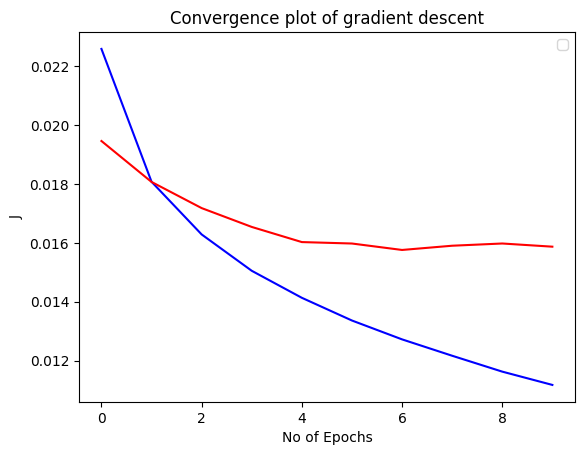

In [56]:
from matplotlib import pyplot as plt
plt.plot(train_history, 'b')
plt.plot(val_history, 'r')
plt.title('Convergence plot of gradient descent')
plt.xlabel('No of Epochs')
plt.ylabel('J')
plt.legend('train loss', 'val loss')
plt.show()

# Exercise: 
Try different initialization, regularization (dropout, l2 regularization), and see the effect on the training and validation error.